In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt


In [3]:
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


## 1. Data Analyzing

### 1.1 Load and read training data

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### 1.2 Check __nan__ value

In [5]:
def show_nan(df:pd.DataFrame):
    missing_val = df.isna().sum() / df.shape[0] * 100
    df_nan = pd.DataFrame({"Colomn":df.columns,"Missing-Rate":missing_val.values})
    

    return df_nan

In [6]:
df_nan = show_nan(train)
print(df_nan)

          Colomn  Missing-Rate
0    PassengerId      0.000000
1     HomePlanet      2.312205
2      CryoSleep      2.496261
3          Cabin      2.289198
4    Destination      2.093639
5            Age      2.059128
6            VIP      2.335212
7    RoomService      2.082135
8      FoodCourt      2.105142
9   ShoppingMall      2.392730
10           Spa      2.105142
11        VRDeck      2.162660
12          Name      2.300702
13   Transported      0.000000


For the value of money , we can reasonably assume that the __nan__ means they did not pay for service, thus we can replace __nan__ by 0

In [7]:
train.RoomService.fillna(0,inplace=True)
train.FoodCourt.fillna(0,inplace=True)
train.ShoppingMall.fillna(0,inplace=True)
train.Spa.fillna(0,inplace=True)
train.VRDeck.fillna(0,inplace=True)


test.RoomService.fillna(0,inplace=True)
test.FoodCourt.fillna(0,inplace=True)
test.ShoppingMall.fillna(0,inplace=True)
test.Spa.fillna(0,inplace=True)
test.VRDeck.fillna(0,inplace=True)

Also as $VIP$ and $CryoSleep$ are related to cost, we can assume __nan__ is 0 

In [8]:
train.VIP.fillna(False,inplace=True)
train.CryoSleep.fillna(False,inplace=True)

test.VIP.fillna(False,inplace=True)
test.CryoSleep.fillna(False,inplace=True)


Split the cabin

In [9]:
train.Cabin = train.Cabin.fillna(method="ffill")
train['Deck'] = train.Cabin.apply(lambda x : x.split("/")[0] )
train['Num'] = train.Cabin.apply(lambda x : x.split("/")[1] )
train['Side'] = train.Cabin.apply(lambda x : x.split("/")[2] )


test.Cabin = test.Cabin.fillna(method="ffill")
test['Deck'] = test.Cabin.apply(lambda x : x.split("/")[0] )
test['Num'] = test.Cabin.apply(lambda x : x.split("/")[1] )
test['Side'] = test.Cabin.apply(lambda x : x.split("/")[2] )


In [10]:
train.drop(columns='Cabin',axis=1,inplace = True)
test.drop(columns='Cabin',axis=1,inplace = True)

Now we split the PassengerNumber into gggg and pp.

In this way, we can fix the __nan__ in $HomePlanet$ by checking the passengers in their groups

In [11]:
train["GroupNumber"] = train.PassengerId.apply(lambda x : x.split("_")[0])
train["InGroupNumber"] = train.PassengerId.apply(lambda x : x.split("_")[1])


test["GroupNumber"] = test.PassengerId.apply(lambda x : x.split("_")[0])
test["InGroupNumber"] = test.PassengerId.apply(lambda x : x.split("_")[1])

In [12]:
Home_Planet_nan_index = train.GroupNumber.loc[train.HomePlanet.isna()].index
Home_Planet_nan_value = train.GroupNumber.loc[train.HomePlanet.isna()].values
Home_Planet_nan_True_value= train.GroupNumber

Home_Planet_nan_dict = dict((k,v) for k, v in zip(Home_Planet_nan_index,Home_Planet_nan_value))

let us check the first one

In [13]:

def fix_Planet(df,dict:dict):
    Planets = [i for i in df.HomePlanet.unique()[0:3]]
   
    for  (indexs,value) in dict.items():
        belong =[i for i in df.HomePlanet.loc[df.GroupNumber == value].values ]
        for belon in belong : 
            if belon in Planets:
                
                df.HomePlanet.loc[df.index ==indexs] = belon          
                
    return df

In [14]:
train= fix_Planet(train,Home_Planet_nan_dict)
print(train.HomePlanet.isnull().sum())

/var/folders/h3/1k8qyncd5dn7cx_3ncvl4yh40000gn/T/ipykernel_4276/3069817309.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.HomePlanet.loc[df.index ==indexs] = belon


111


In [15]:
Home_Planet_nan_index = test.GroupNumber.loc[test.HomePlanet.isna()].index
Home_Planet_nan_value = test.GroupNumber.loc[test.HomePlanet.isna()].values
Home_Planet_nan_True_value= test.GroupNumber

Home_Planet_nan_dict = dict((k,v) for k, v in zip(Home_Planet_nan_index,Home_Planet_nan_value))

test= fix_Planet(test,Home_Planet_nan_dict)

/var/folders/h3/1k8qyncd5dn7cx_3ncvl4yh40000gn/T/ipykernel_4276/3069817309.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.HomePlanet.loc[df.index ==indexs] = belon


Here still half of nan in HomePlanet , that's because they are groups with single person. Thus we use "ffill" to fillna()

In [16]:
train.HomePlanet.fillna(method='ffill',inplace=True)
test.HomePlanet.fillna(method='ffill',inplace=True)
print(train.HomePlanet.isnull().sum())



0


In [17]:
Destination_nan_index = train.GroupNumber.loc[train.Destination.isna()].index
Destination_nan_value = train.GroupNumber.loc[train.Destination.isna()].values


Destination_nan_dict = dict((k,v) for k, v in zip(Home_Planet_nan_index,Home_Planet_nan_value))

In [18]:
def fix_Destination(df,dict:dict):
    Planets = [i for i in df.Destination.unique()[0:3]]
   
    for  (indexs,value) in dict.items():
        belong =[i for i in df.Destination.loc[df.GroupNumber == value].values ]
        for belon in belong : 
            if belon in Planets:
                
                df.Destination.loc[df.index ==indexs] = belon          
                
    return df

In [19]:
train= fix_Destination(train,Destination_nan_dict)
train.Destination.fillna(method='ffill',inplace=True)

In [20]:
Destination_nan_index = test.GroupNumber.loc[test.Destination.isna()].index
Destination_nan_value = test.GroupNumber.loc[test.Destination.isna()].values


Destination_nan_dict = dict((k,v) for k, v in zip(Home_Planet_nan_index,Home_Planet_nan_value))

test= fix_Destination(test,Destination_nan_dict)
test.Destination.fillna(method='ffill',inplace=True)

/var/folders/h3/1k8qyncd5dn7cx_3ncvl4yh40000gn/T/ipykernel_4276/917726138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Destination.loc[df.index ==indexs] = belon


In [21]:
df_nan = show_nan(train)
df_nan

,Colomn,Missing-Rate
0,PassengerId,0.000000
1,HomePlanet,0.000000
2,CryoSleep,0.000000
3,Destination,0.000000
4,Age,2.059128
5,VIP,0.000000
6,RoomService,0.000000
7,FoodCourt,0.000000
8,ShoppingMall,0.000000
9,Spa,0.000000


Now using the groups and surnames we can check how many relatives are there in same group

In [22]:
train.Name.fillna(method="ffill",inplace=True)
relatives = pd.DataFrame(train.groupby(['GroupNumber'])['Name'])
names=list(relatives[1][0])
print(names[0].split(" "))

['Maham', 'Ofracculy']


In [23]:
d = {}

for i in range(len(relatives)):
    past_last_names = []
    names= list(relatives[1][i])
    rltvs = 1
    for j in range(len(relatives[1][i])):
        name =  names[j].split(" ")
        if name in past_last_names:
            rltvs+=1
        past_last_names.append(name)
    d["{}".format(relatives[0][i])] = rltvs

train["HasRelatives"] = train["GroupNumber"].map(d)



In [24]:
test.Name.fillna(method="ffill",inplace=True)
relatives = pd.DataFrame(test.groupby(['GroupNumber'])['Name'])
names=list(relatives[1][0])
print(names[0].split(" "))

d = {}

for i in range(len(relatives)):
    past_last_names = []
    names= list(relatives[1][i])
    rltvs = 1
    for j in range(len(relatives[1][i])):
        name =  names[j].split(" ")
        if name in past_last_names:
            rltvs+=1
        past_last_names.append(name)
    d["{}".format(relatives[0][i])] = rltvs

test["HasRelatives"] = test["GroupNumber"].map(d)

['Nelly', 'Carsoning']


In [25]:
mean_age = train.Age.dropna().values.mean()
print(mean_age)
train.Age = train.Age.fillna(mean_age)

train.drop(['GroupNumber',"InGroupNumber","Name"],axis=1,inplace=True)

train['IsAdult'] = True
train.IsAdult.loc[train.Age < 18] = False

28.82793046746535


/var/folders/h3/1k8qyncd5dn7cx_3ncvl4yh40000gn/T/ipykernel_4276/3663475641.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.IsAdult.loc[train.Age < 18] = False


In [26]:
mean_age = test.Age.dropna().values.mean()
print(mean_age)
test.Age = test.Age.fillna(mean_age)

test.drop(['GroupNumber',"InGroupNumber","Name"],axis=1,inplace=True)

test['IsAdult'] = True
test.IsAdult.loc[test.Age < 18] = False

28.65814620162446


/var/folders/h3/1k8qyncd5dn7cx_3ncvl4yh40000gn/T/ipykernel_4276/260363428.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.IsAdult.loc[test.Age < 18] = False


In [27]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,HasRelatives,IsAdult
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,1,True
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,1,True
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,1,True
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,1,True
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,1,False


In [28]:
train['TotalCost'] = train.RoomService + train.FoodCourt + train.ShoppingMall + train.Spa + train.VRDeck
test['TotalCost'] = test.RoomService + test.FoodCourt + test.ShoppingMall + test.Spa + test.VRDeck

## 2 Data Preprocessing and Analyzing

In [29]:
Cate = ["HomePlanet","CryoSleep","Destination","VIP","IsAdult","Deck","Num","Side"]

for cat in Cate: 
    label = LabelEncoder()
    arr = np.concatenate((train[cat],test[cat])).astype(str)
    label.fit(arr)

    train[cat] = label.transform(train[cat].astype(str))
    test[cat] = label.transform(test[cat].astype(str))


In [30]:
t = train.Transported
train.drop("Transported",axis=1,inplace=True)
train['Transported'] = t

train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Num,Side,HasRelatives,IsAdult,TotalCost,Transported
0,0001_01,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1,0.0,False
1,0002_01,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,5,0,1,1,1,736.0,True
2,0003_01,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,1,1,1,10383.0,False
3,0003_02,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,1,1,1,5176.0,False
4,0004_01,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,5,1,1,1,0,1091.0,True


### 2.2 Data Visualization

<AxesSubplot:>

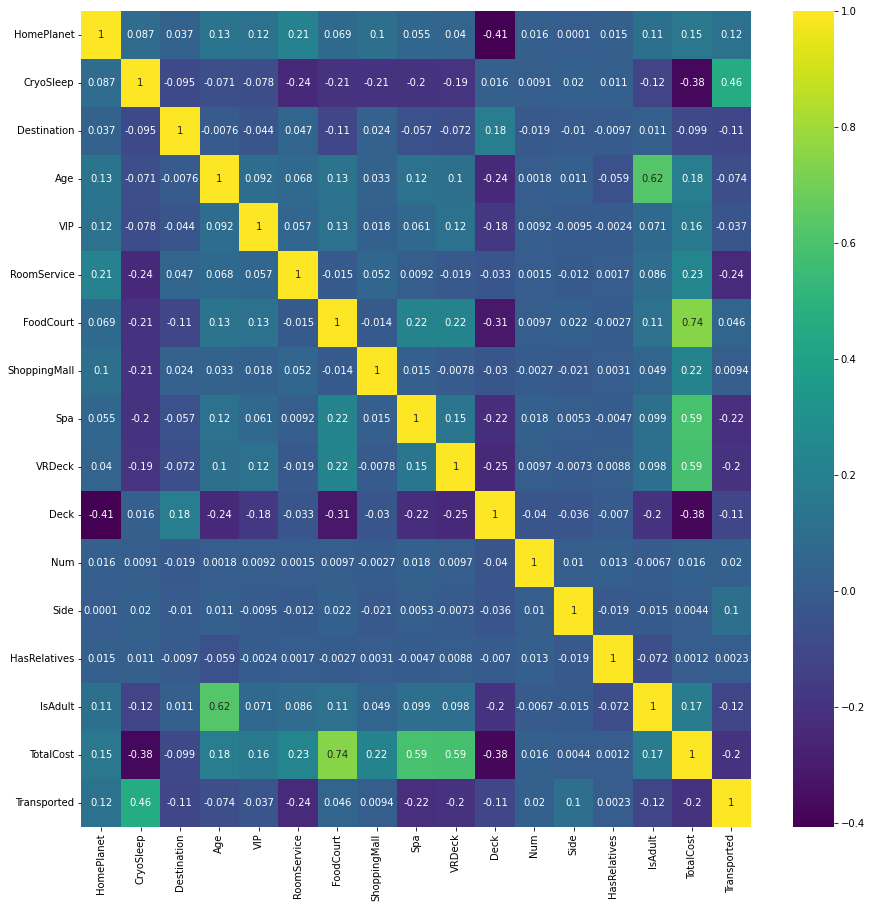

In [31]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(),annot=True,cmap="viridis")

Text(0.5, 1.0, 'Age distribution')

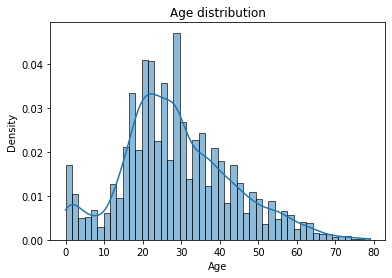

In [32]:
sns.histplot(train,x = 'Age',kde=True,stat='density')
plt.title("Age distribution")

## 3 Machine Learning 

### 3.1 Split dataset

In [33]:
y = train.Transported.astype(int)
X = train.drop(columns=['PassengerId','Transported'])


In [34]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=40)

### 3.2 Compare different model

In [35]:
folder = KFold(n_splits=5)
svc = SVC(max_iter=250)
rfc = RandomForestClassifier()
lgr = LogisticRegression(max_iter=250)

score = cross_val_score(rfc,X_train,y_train,cv = folder)


In [36]:
score

array([0.77785766, 0.8116463 , 0.7821711 , 0.80733285, 0.81007194])

In [37]:

rfc=LogisticRegression(C= 0.1,max_iter=500)
rfc.fit(X,y)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1, max_iter=500)

In [38]:
y_true = pd.read_csv("sample_submission.csv")
y_true = y_true.Transported.values

In [39]:
X_test = test.drop(columns=['PassengerId'])
pred = rfc.predict(X_test)

print(np.mean(y_true == pred))

0.4779050736497545
